This notebook identifies practices as part of our outlier detection who prescribed promazine. The intention is that we write to them and outlying CCGs to ascertain the reasons why they use this so much compared to their peers.

In [1]:
#import libraries required for analysis
import os
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from ebmdatalab import bq, charts, maps

Data Extract Here we identify all promazine prescribing. We identify all prescribing to generate measures for letters.

In [2]:
#code from original notebook - not used as CCG codes changed 
#sql = """
#SELECT
#  month,
#  pct,
#  practice,
#  name,
#  address1, 
#  address2, 
#  address4, 
#  address5, 
#  postcode,
#  SUM(items) AS total_promzazine
#FROM
#  ebmdatalab.hscic.normalised_prescribing_standard AS presc
#INNER JOIN
#  ebmdatalab.hscic.practices prac
#ON
#  presc.practice = prac.code
#  AND (prac.setting = 4)
#WHERE
#  bnf_code LIKE "0402010S0%" 
###  AND
### (presc.month >= "2019-03-01" and presc.month  <= "2019-06-01")
# ## AND items > 1
#GROUP BY
#  month,
#  pct,
#  practice,
#  name,
#  address1, 
#  address2, 
#  address4, 
#  address5, 
#  postcode
#ORDER BY
#  presc.month,
#  practice
#"""

#promazine = bq.cached_read(sql, csv_path='pericyazine_df.csv')
#prmazine['month'] = pericyazine['month'].astype('datetime64[ns]')
#promazine.head(10)
importfile = os.path.join("..","data","promazine_df.csv") #set path for data cache
promazine = pd.read_csv(importfile)
promazine['month'] = promazine['month'].astype('datetime64[ns]')
promazine.head(10)

,month,pct,practice,name,address1,address2,address4,address5,postcode,total_promazine
0,2010-08-01,16C,A81003,VICTORIA MEDICAL PRACTICE,THE HEALTH CENTRE,VICTORIA ROAD,CLEVELAND,NaN,TS26 8DB,2
1,2010-08-01,16C,A81004,ACKLAM MEDICAL CENTRE,TRIMDON AVENUE,ACKLAM,NaN,NaN,TS5 8SB,1
2,2010-08-01,16C,A81007,BANKHOUSE SURGERY,ONE LIFE HARTLEPOOL,PARK ROAD,CLEVELAND,NaN,TS24 7PW,14
3,2010-08-01,16C,A81011,CHADWICK PRACTICE,ONE LIFE HARTLEPOOL,PARK ROAD,CLEVELAND,NaN,TS24 7PW,22
4,2010-08-01,16C,A81017,WOODBRIDGE PRACTICE,THE HEALTH CENTRE,"TRENCHARD AVE, THORNABY",CLEVELAND,NaN,TS17 0EE,3
5,2010-08-01,16C,A81022,HILLSIDE PRACTICE,HILLSIDE PRACTICE,"WINDERMERE DRIVE,SKELTON",CLEVELAND,NaN,TS12 2TG,1
6,2010-08-01,16C,A81027,YARM MEDICAL PRACTICE,YARM MEDICAL PRACTICE,MULBERRY HOUSE,"YARM, CLEVELAND",NaN,TS15 9DD,1
7,2010-08-01,16C,A81031,HAVELOCK GRANGE PRACTICE,ONE LIFE HARTLEPOOL,PARK ROAD,CLEVELAND,NaN,TS24 7PW,28
8,2010-08-01,16C,A81036,NORTON MEDICAL CENTRE,NORTON MEDICAL CENTRE,"BILLINGHAM ROAD, NORTON",CLEVELAND,NaN,TS20 2UZ,3
9,2010-08-01,16C,A81041,HART MEDICAL PRACTICE,HART MEDICAL PRACTICE,SURGERY LANE,CLEVELAND,NaN,TS24 9DN,33


Here we identify the practices for writing to based on criteria in our methodology

- prescribing in last quarter
- at least 1 item

In [3]:
promazine_prescribers = promazine.loc[(promazine["month"]>= "2019-03-01") & (promazine["month"] <= "2019-06-01") & (promazine["total_promazine"] > 1)]
promazine_prescribers.head()

,month,pct,practice,name,address1,address2,address4,address5,postcode,total_promazine
168307,2019-03-01,16C,A81007,BANKHOUSE SURGERY,ONE LIFE HARTLEPOOL,PARK ROAD,CLEVELAND,NaN,TS24 7PW,11
168309,2019-03-01,16C,A81011,CHADWICK PRACTICE,ONE LIFE HARTLEPOOL,PARK ROAD,CLEVELAND,NaN,TS24 7PW,11
168312,2019-03-01,16C,A81026,LINTHORPE SURGERY,378 LINTHORPE ROAD,MIDDLESBROUGH,NaN,NaN,TS5 6HA,2
168313,2019-03-01,16C,A81031,HAVELOCK GRANGE PRACTICE,ONE LIFE HARTLEPOOL,PARK ROAD,CLEVELAND,NaN,TS24 7PW,42
168314,2019-03-01,16C,A81041,HART MEDICAL PRACTICE,HART MEDICAL PRACTICE,SURGERY LANE,CLEVELAND,NaN,TS24 9DN,4


In [4]:
promazine_prescribers['practice'].nunique()

1137

In [5]:
#code from old notebook - used csvs created at the time
# get data for patient list size (all patients) so we can create a measure
#sql2 = """
#SELECT month,
#pct_id AS pct,
#practice,
#sum(total_list_size) as list_size
#FROM ebmdatalab.hscic.practice_statistics
#group by 
#month,
#pct,
#practice
#order by
#month, pct
#"""
#listsize_df = bq.cached_read(sql2, csv_path='list_size.csv')
#listsize_df['month'] = listsize_df['month'].astype('datetime64[ns]')
importfile = os.path.join("..","data","list_size.csv") #set path for data cache
listsize_df = pd.read_csv(importfile)
listsize_df['month'] = listsize_df['month'].astype('datetime64[ns]')

In [6]:
#merge dataframes so we can do measures with deciles
promazine_per_1000 = pd.merge(left = listsize_df, right = promazine, on=['month', 'practice'], how = 'left')
promazine_per_1000['promazine_per_1000'] = 1000* (promazine_per_1000['total_promazine']/promazine_per_1000['list_size'])
promazine_per_1000['promazine_per_1000'] = promazine_per_1000['promazine_per_1000'].fillna(0)
promazine_per_1000.head(5)

,month,pct_x,practice,list_size,pct_y,name,address1,address2,address4,address5,postcode,total_promazine,promazine_per_1000
0,2014-07-01,NaN,Y00613,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,2014-07-01,NaN,Y00031,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,2014-07-01,NaN,Y02926,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3,2014-07-01,00C,Y00142,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,2014-07-01,00C,Y00382,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


In [8]:
exportfile = os.path.join("..","data","promazine_per_1000.csv") #set path for data cache
promazine_per_1000.to_csv(exportfile,index=False)

/root/.pyenv/versions/3.8.1/lib/python3.8/site-packages/ebmdatalab/charts.py:95: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b:" (-> color='b'). The keyword argument will take precedence.
  ax.plot(
/root/.pyenv/versions/3.8.1/lib/python3.8/site-packages/ebmdatalab/charts.py:95: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b:" (-> color='b'). The keyword argument will take precedence.
  ax.plot(
/root/.pyenv/versions/3.8.1/lib/python3.8/site-packages/ebmdatalab/charts.py:95: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b:" (-> color='b'). The keyword argument will take precedence.
  ax.plot(
/root/.pyenv/versions/3.8.1/lib/python3.8/site-packages/ebmdatalab/charts.py:95: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b:" (-> color='b'). The keyword argument will take precedence.
  ax.plot(
/roo

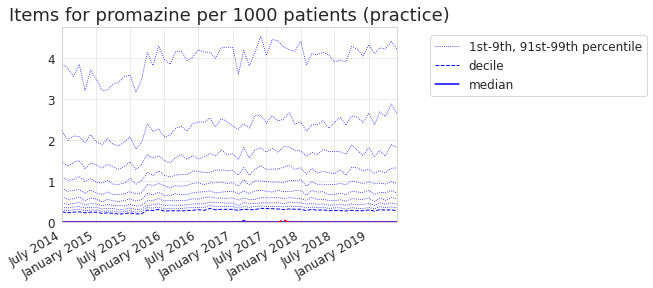

In [9]:
#create sample deciles chart
charts.deciles_chart(
        promazine_per_1000,
        period_column='month',
        column='promazine_per_1000',
        title="Items for promazine per 1000 patients (practice)",
        show_outer_percentiles=True)

#add in example https://openprescribing.net/practice/D82099/ from West Norfolk
df_subject = promazine_per_1000.loc[promazine_per_1000['practice'] == 'D82099']
plt.plot(df_subject['month'], df_subject['promazine_per_1000'], 'r--')
plt.show()

In [10]:
ccg_promazine = promazine_per_1000.groupby(['pct_x', 'month']).sum().reset_index()
ccg_promazine['promazine_per_1000'] = 1000* (ccg_promazine['total_promazine']/ccg_promazine['list_size'])
ccg_promazine['promazine_per_1000'] = ccg_promazine['promazine_per_1000'].fillna(0)
ccg_promazine.rename(columns = {'pct_x':'pct'}, inplace = True)
ccg_promazine = ccg_promazine.loc[(ccg_promazine["list_size"] >= 2000)]
ccg_promazine.head(5)

,pct,month,list_size,address5,total_promazine,promazine_per_1000
0,00C,2014-07-01,106620,0.0,5.0,0.046896
1,00C,2014-08-01,106620,0.0,2.0,0.018758
2,00C,2014-09-01,106620,0.0,0.0,0.000000
3,00C,2014-10-01,106624,0.0,0.0,0.000000
4,00C,2014-11-01,106624,0.0,0.0,0.000000


/root/.pyenv/versions/3.8.1/lib/python3.8/site-packages/ebmdatalab/charts.py:95: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b:" (-> color='b'). The keyword argument will take precedence.
  ax.plot(
/root/.pyenv/versions/3.8.1/lib/python3.8/site-packages/ebmdatalab/charts.py:95: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b:" (-> color='b'). The keyword argument will take precedence.
  ax.plot(
/root/.pyenv/versions/3.8.1/lib/python3.8/site-packages/ebmdatalab/charts.py:95: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b:" (-> color='b'). The keyword argument will take precedence.
  ax.plot(
/root/.pyenv/versions/3.8.1/lib/python3.8/site-packages/ebmdatalab/charts.py:95: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b:" (-> color='b'). The keyword argument will take precedence.
  ax.plot(
/roo

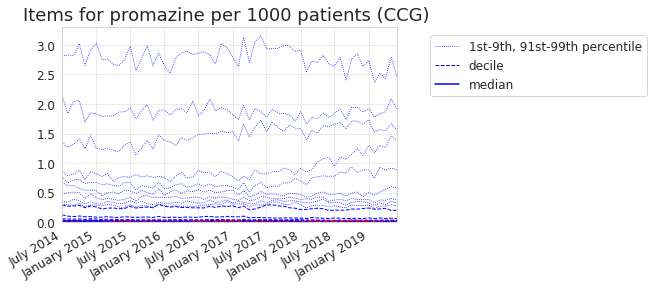

In [11]:
#create sample deciles chart
charts.deciles_chart(
        ccg_promazine,
        period_column='month',
        column='promazine_per_1000',
        title="Items for promazine per 1000 patients (CCG) ",
        show_outer_percentiles=True)

#add in example Islington is 08H
df_subject = ccg_promazine.loc[ccg_promazine['pct'] == '08H']
plt.plot(df_subject['month'], df_subject['promazine_per_1000'], 'r--')
plt.show()

In [13]:
## here we look at CCGs that are outliers.
latest_ccg = ccg_promazine.loc[(ccg_promazine["month"] == "2017-08-01")]
latest_ccg.sort_values("total_promazine", ascending=False).head(250)

,pct,month,list_size,address5,total_promazine,promazine_per_1000
664,00T,2017-08-01,307820,0.0,1826.0,5.932038
1843,01Y,2017-08-01,246915,0.0,751.0,3.041533
1237,01G,2017-08-01,268668,0.0,736.0,2.739440
724,00V,2017-08-01,203187,0.0,600.0,2.952945
1723,01W,2017-08-01,310944,0.0,597.0,1.919960
...,...,...,...,...,...,...
3418,03M,2017-08-01,119991,0.0,0.0,0.000000
4012,04D,2017-08-01,237264,0.0,0.0,0.000000
11419,12D,2017-08-01,234499,0.0,0.0,0.000000
9196,09H,2017-08-01,132292,0.0,0.0,0.000000


In [14]:
exportfile = os.path.join("..","data","latest_ccg.csv") #set path for data cache
latest_ccg.to_csv(exportfile,index=False)

In [15]:
#create choropeth map of cost per 1000 patients using bespoke map function (derived from ebmdatalab library)
import glob
import geopandas as gpd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from pathlib import Path


def ccg_map_bespoke(
    df,
    title="",
    column=None,
    region=None,
    separate_region=False,
    region_layout="horizontal",
    cartogram=False,
    subplot_spec=None,
    show_legend=True,
    map_year=None,
    plot_options=None,
):
    """Draw a CCG map with area separated out
    """
    # Because this uses subplots to arrange London and England,
    # the only way to arrange nested subplots is via a subplotspec
    assert column, "You must specify a column name to plot"
    df = df.copy()
    # input df must have 'pct' column, plus others as specified
    data_dir = os.path.join("..","data")

    # Add names and if it's London. Note the names in ccg_for_map must
    # match names in the CCG geojson, as that doesn't include codes at
    # the momemt
    map_name = os.path.join(data_dir, "ccg_for_map.csv")
    names = pd.read_csv(map_name)

    # Check we know about all the codes in the input data
    diff = np.setdiff1d(df["pct"], names["code"])
    if len(diff) > 0:
        raise BaseException(
            "Data contains CCG codes we don't know about: {}".format(diff)
        )

    df = df.merge(names[["code", "name", "region"]], left_on="pct", right_on="code")
    df = df.set_index("name")

    # Load map data
    cartogram_suffix = ""
    if cartogram:
        cartogram_suffix = "_cartogram"
    if map_year:
        map_file = os.path.join(data_dir,"ccgs{}_{}.json").format(cartogram_suffix, map_year)
    else:
        map_file = sorted(
            glob.glob(str(os.path.join(data_dir,"ccgs{}_2*.json").format(cartogram_suffix)))
        )[-1]
    ccgs = gpd.read_file(map_file)
    # Normalise names to match `ccg_fo_map` format (above)
    ccgs["name"] = ccgs["name"].str.upper()
    ccgs = ccgs.set_index("name")
    # Remove ones without geometry - these are (usually) federations
    # rather than individual CCGs
    ccgs = ccgs[~ccgs["geometry"].isnull()]

    # Check we can map all the CCGs named in the input data
    diff = np.setdiff1d(df.index, ccgs.index)
    if len(diff) > 0:
        raise BaseException("Data contains CCG names we can't map: {}".format(diff))

    # Join map with data
    gdf = ccgs.join(df, rsuffix="_orig")

    # Split into london and rest of England
    gdf_region = gdf[gdf["region"] == region]
    gdf_roe = gdf

    # set common value limits for colour scale
    default_plot_options = {
        'vmin': df[column].min(),
        'vmax': df[column].max(),
        'edgecolor': "black",
        'linewidth': 0.1,
        'cmap': "OrRd",
    }

    if plot_options is None:
        plot_options = {}

    for k, v in default_plot_options.items():
        if k not in plot_options:
            plot_options[k] = v

    def plot(gdf, ax, title="", legend=True):
        gdf.plot(
            ax=ax,
            column=column,
            legend=legend,
            **plot_options
        )
        ax.set_aspect(1.63)
        if title:
            ax.set_title(title, size=12)
        ax.axis("off")

    fig = plt.gcf()
    if not subplot_spec:
        subplot_spec = gridspec.GridSpec(1, 1)[0]
    if separate_region:
        if region_layout == "horizontal":
            gs = gridspec.GridSpecFromSubplotSpec(
                nrows=1, ncols=2, width_ratios=[1, 2], subplot_spec=subplot_spec
            )
            ldn_ax = fig.add_subplot(gs[0, 0])
            roe_ax = fig.add_subplot(gs[0, 1])
        else:
            gs = gridspec.GridSpecFromSubplotSpec(
                nrows=2, ncols=1, height_ratios=[2, 1], subplot_spec=subplot_spec
            )
            roe_ax = fig.add_subplot(gs[0, 0])
            ldn_ax = fig.add_subplot(gs[1, 0])

        plot(
            gdf_roe,
            roe_ax,
            title="England".format(title),
            legend=show_legend,
        )
        plot(gdf_region, ldn_ax, title=region.format(title), legend=False)
    else:
        ax = plt.subplot(subplot_spec)
        plot(gdf, ax, title=title, legend=show_legend)
    fig.suptitle(title, fontsize='large')
    return plt

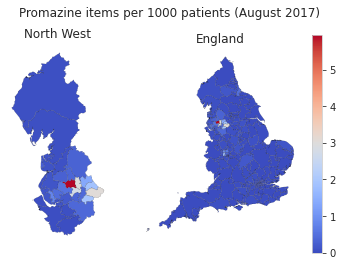

In [18]:
plt = ccg_map_bespoke(
    latest_ccg, 
    title="Promazine items per 1000 patients (August 2017)", 
    map_year = '2018',
    column='promazine_per_1000', region='North West', separate_region=True,
    plot_options={'cmap': 'coolwarm'}
    )
exportfile = os.path.join("..","data","promazine_map.png")
plt.savefig(exportfile, dpi=300)